## Problem Statement Given

You are owing a supermarket mall and through membership cards , you have some basic data about your customers like Customer ID, age, gender, annual income and spending score.
Spending Score is something you assign to the customer based on your defined parameters like customer behavior and purchasing data.

You own the mall and want to understand the customers like who can be easily converged [Target Customers] so that the sense can be given to marketing team and plan the strategy accordingly.



## Data Dictionary

1. **CustomerID** : Unique ID assigned to the customer
2. **Gender** : Gender of the customer
3. **Age** : Age of the customer
4. **Annual Income (k$)** : Annual Income of the customer
5. **Spending Score (1-100)** : Score assigned by the mall based on customer behavior and spending nature

In this Project, first I have done the Exploratory Data Analysis. Then I implemented the various clustering algorithms from scratch. Then I used evaluation metrics like Silhouette Score and DB index to find out which is the best clustering algorithm in  this case.

In [64]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.spatial.distance import pdist, squareform

In [65]:
df = pd.read_csv('/content/drive/MyDrive/Mall_Customers.csv')

In [66]:
df

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
...,...,...,...,...,...
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18


In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [68]:
df['Gender'] = df['Gender'].astype('category')
df

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
...,...,...,...,...,...
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18


Statistical Summary of the data :     

1. Age varies between 18 and 70 with a mean age of about 39.
2. Annual Income varies between 15 k\$ and 137 k\$ with a mean annual income of about 60.56 k$.
3. Spending Score varies between 1 and 99 with a mean age of about 50.

## Feature Engineering

In [69]:
le = LabelEncoder()
df['Gender_Code'] = le.fit_transform(df['Gender'])
print("\nEncoded 'Gender' as numeric (Gender_Code).")


Encoded 'Gender' as numeric (Gender_Code).


In [70]:
features = df[['Gender_Code', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)']]
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
print("Features scaled (standardization).")

Features scaled (standardization).


In [71]:
pca = PCA(n_components=3)
components = pca.fit_transform(features_scaled)
df['PCA1'] = components[:, 0]
df['PCA2'] = components[:, 1]
df['PCA3'] = components[:, 2]
print("PCA completed. \nExplained variance ratios:", pca.explained_variance_ratio_)

PCA completed. 
Explained variance ratios: [0.33690046 0.26230645 0.23260639]


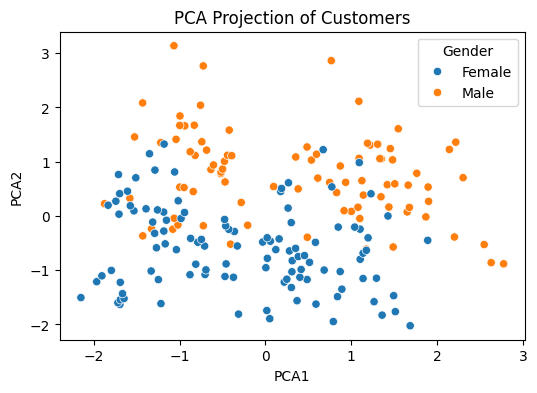

In [72]:
plt.figure(figsize=(6, 4))
sns.scatterplot(x='PCA1', y='PCA2', hue='Gender', data=df)
plt.title('PCA Projection of Customers')
plt.show()

## Clustering Algorithms

###  K Means Algorithm (Hard Clustering)



In [73]:
def kmeans(X, K, max_iters=100, tol=1e-4):
    """
    K-Means clustering algorithm from scratch.
    - X: data array of shape (n_samples, n_features)
    - K: number of clusters
    Returns cluster labels and centroid coordinates.
    """
    n_samples, n_features = X.shape
    rng = np.random.default_rng(42)
    # Step 1: Randomly initializing centroids by sampling K distinct points
    initial_idx = rng.choice(n_samples, K, replace=False)
    centroids = X[initial_idx].copy()

    for iteration in range(max_iters):
        # Step 2: Assigning points to nearest centroid
        # Computeing distance matrix: shape (n_samples, K)
        distances = np.linalg.norm(X[:, None] - centroids[None, :], axis=2)
        labels = np.argmin(distances, axis=1)

        # Step 3: Updating centroids as the mean of assigned points
        new_centroids = np.zeros((K, n_features))
        for k in range(K):
            points = X[labels == k]
            if len(points) > 0:
                new_centroids[k] = points.mean(axis=0)
            else:
                # If a cluster is empty, reinitialize its centroid randomly
                new_centroids[k] = X[rng.choice(n_samples)]

        # Checking convergence (centroid shift)
        shift = np.linalg.norm(new_centroids - centroids)
        if shift < tol:
            break
        centroids = new_centroids

    # Final assignment after convergence
    distances = np.linalg.norm(X[:, None] - centroids[None, :], axis=2)
    labels = np.argmin(distances, axis=1)
    return labels, centroids

# Example: apply K-Means with K=5
labels_km, centroids_km = kmeans(components, K=5)


### Fuzzy C-Means (Soft Clustering)

In [74]:
def fuzzy_c_means(X, C=5, m=2.0, max_iters=100, tol=1e-4):
    """
    Fuzzy C-means clustering:
    - X: data array (n_samples, n_features)
    - C: number of clusters
    - m: fuzziness component (>1, higher => more fuzzy)
    Returns: membership matrix U (C x n_samples), cluster centers, and final labels.
    """
    N = X.shape[0]
    rng = np.random.default_rng(42)
    # Step 1: Initializing random membership weights (C x N) and normalising columns
    U = rng.random((C, N))
    U = U / np.sum(U, axis=0, keepdims=True)

    for iteration in range(max_iters):
        U_old = U.copy()
        # Step 2: Computing cluster centers
        centers = np.zeros((C, X.shape[1]))
        for j in range(C):
            u_jm = U[j]**m
            centers[j] = np.dot(u_jm, X) / np.sum(u_jm)
        # Step 3: Updating membership weights
        dist = np.zeros((C, N))
        for j in range(C):
            dist[j] = np.linalg.norm(X - centers[j], axis=1) + 1e-8  # add epsilon
        for j in range(C):
            # Updating membership for cluster j
            U[j] = 1.0 / np.sum((dist[j] / dist)**(2/(m-1)), axis=0)
        # Convergence check
        if np.linalg.norm(U - U_old) < tol:
            break

    labels = np.argmax(U, axis=0)  # assigning each point to cluster with highest membership
    return U, centers, labels


U, centers_fc, labels_fc = fuzzy_c_means(components, C=5, m=2.0)


In [75]:
U

array([[0.15263246, 0.19120306, 0.10859011, 0.31884732, 0.14881695,
        0.32472103, 0.08137383, 0.34210316, 0.0944596 , 0.29015291,
        0.09265875, 0.33148605, 0.0973214 , 0.33534802, 0.09146452,
        0.1834789 , 0.09615205, 0.17210788, 0.08218658, 0.35204794,
        0.10878105, 0.16553261, 0.08419879, 0.15228522, 0.08604068,
        0.16052137, 0.04726439, 0.130683  , 0.03961728, 0.40130515,
        0.08128607, 0.40522419, 0.07104701, 0.19763216, 0.07279124,
        0.43235794, 0.04676313, 0.40095229, 0.00885356, 0.47155852,
        0.07904041, 0.17115964, 0.05639667, 0.36388284, 0.04611318,
        0.4772913 , 0.00563538, 0.30518921, 0.20180192, 0.15917605,
        0.00371651, 0.10132961, 0.33266504, 0.05063534, 0.0110282 ,
        0.05478464, 0.0074114 , 0.04597964, 0.43583983, 0.03820668,
        0.0354409 , 0.08488203, 0.06259892, 0.01563297, 0.02609968,
        0.08455503, 0.06095632, 0.06937068, 0.08064882, 0.26185163,
        0.02960525, 0.02710937, 0.05148921, 0.04

In [76]:
centers_fc

array([[-1.18815379, -0.13245978, -0.60967652],
       [-0.70121401,  0.91466813,  0.86580177],
       [ 0.52274592, -0.21995366, -0.99104488],
       [ 0.32828886, -1.13607312, -0.21028335],
       [ 1.2859599 ,  0.54927984,  0.58089177]])

In [77]:
labels_fc

array([1, 1, 3, 0, 3, 0, 3, 0, 4, 3, 4, 0, 3, 0, 4, 1, 3, 1, 4, 0, 4, 1,
       3, 1, 3, 1, 3, 1, 3, 0, 4, 0, 4, 1, 3, 0, 3, 0, 3, 0, 3, 1, 4, 0,
       3, 0, 3, 3, 3, 3, 3, 1, 3, 4, 3, 4, 3, 4, 0, 4, 4, 1, 3, 3, 4, 1,
       3, 3, 1, 3, 4, 3, 3, 3, 4, 1, 3, 4, 0, 3, 4, 1, 4, 3, 0, 4, 3, 0,
       0, 2, 2, 1, 4, 2, 0, 1, 2, 0, 4, 1, 0, 2, 4, 1, 4, 0, 2, 4, 4, 4,
       4, 0, 2, 1, 0, 0, 2, 2, 2, 2, 1, 2, 0, 1, 0, 0, 4, 1, 4, 1, 4, 1,
       0, 0, 4, 0, 2, 1, 4, 0, 2, 1, 0, 0, 4, 1, 4, 0, 2, 1, 4, 1, 2, 0,
       2, 0, 4, 0, 4, 0, 2, 0, 4, 0, 4, 0, 4, 0, 2, 1, 4, 1, 4, 1, 2, 0,
       4, 1, 4, 1, 2, 0, 4, 0, 2, 1, 2, 1, 2, 0, 2, 0, 4, 0, 2, 0, 2, 1,
       4, 1])

### DBSCAN (Density Based Spatial Clustering of Applications with Noise)

In [78]:
def dbscan(X, eps, min_pts):
    """
    DBSCAN clustering from scratch.
    - X: data array (n_samples, n_features)
    - eps: radius to consider for neighbors
    - min_pts: minimum number of points to form a dense region
    Returns array of cluster labels (-1 indicates noise).
    """
    N = X.shape[0]
    labels = np.full(N, -1, dtype=int)  # initializing all as noise (-1)
    visited = np.zeros(N, dtype=bool)
    cluster_id = 0
    # Precomputing pairwise distance matrix to speed up
    dist_mat = np.linalg.norm(X[:, None] - X[None, :], axis=2)
    neighbors = [np.where(dist_mat[i] <= eps)[0] for i in range(N)]

    for i in range(N):
        if visited[i]:
            continue
        visited[i] = True
        nbrs = neighbors[i]
        if len(nbrs) < min_pts:
            # Too few neighbors => mark as (temporary) noise
            labels[i] = -1
        else:
            # Start a new cluster
            labels[i] = cluster_id
            cluster_queue = list(nbrs)
            # Expand cluster
            k = 0
            while k < len(cluster_queue):
                j = cluster_queue[k]
                if not visited[j]:
                    visited[j] = True
                    nbrs_j = neighbors[j]
                    if len(nbrs_j) >= min_pts:
                        # Add new neighbors to queue
                        for n in nbrs_j:
                            if n not in cluster_queue:
                                cluster_queue.append(n)
                # Assign to cluster if not yet assigned
                if labels[j] == -1:
                    labels[j] = cluster_id
                k += 1
            cluster_id += 1
    return labels

labels_db = dbscan(components, eps=0.5, min_pts=5)


In [79]:
labels_db

array([ 1,  1, -1,  0, -1,  0,  2,  0, -1,  0, -1,  0,  2,  0, -1,  1,  2,
        1, -1,  0, -1,  1,  2,  1,  2,  1,  2, -1,  2,  0, -1,  0, -1, -1,
        2,  0,  2,  0,  2,  0,  2, -1,  3,  2,  2,  0,  2,  2,  2,  2,  2,
        4,  2,  3,  2,  3,  2,  3,  2,  3,  3,  4,  2,  2,  3, -1,  2,  2,
       -1,  2,  3,  2,  2,  2,  3,  4,  2,  3,  2,  2,  3,  3,  3,  2,  2,
        3,  2,  2,  2,  2,  2,  4,  3,  2,  2,  4,  2,  2,  3,  4,  2,  2,
        3,  4,  3,  2,  2,  3,  3,  3,  3,  2,  2,  4,  2,  2,  2,  2,  2,
        2,  4,  2,  2,  4,  2,  2,  3,  4, -1,  4,  3,  4,  2,  2,  3,  2,
        5,  4,  3,  2, -1,  4,  2,  2,  3,  4,  3,  2,  2,  4,  3,  4,  5,
        2,  5,  2,  3,  2,  3,  2,  5,  2,  3,  2,  3,  2,  3,  2, -1,  4,
        3,  4,  3,  4, -1,  2, -1,  4, -1,  4, -1,  2,  3,  2, -1, -1, -1,
        4, -1,  2, -1,  2, -1,  2, -1, -1, -1, -1, -1, -1])

### Hierarchical Clustering -> Agglomerative Clustering

In [80]:
def hierarchical_clustering(X, k=5, method='complete'):
    """
    Agglomerative hierarchical clustering.
    - X: data array (n_samples, n_features)
    - k: number of final clusters desired
    - method: linkage ('single', 'complete', or 'average')
    Returns cluster labels of length n_samples.
    """
    N = X.shape[0]
    # Initially each point is its own cluster
    clusters = [[i] for i in range(N)]
    # Precompute all pairwise distances
    dist_mat = squareform(pdist(X))

    # Merging until k clusters remain
    while len(clusters) > k:
        # Finding closest pair of clusters
        min_dist = float('inf')
        pair_to_merge = (-1, -1)
        for i in range(len(clusters)):
            for j in range(i+1, len(clusters)):
                if method == 'single':
                    d = np.min(dist_mat[np.ix_(clusters[i], clusters[j])])
                elif method == 'complete':
                    d = np.max(dist_mat[np.ix_(clusters[i], clusters[j])])
                elif method == 'average':
                    # Average distance between all points in the two clusters
                    sub = dist_mat[np.ix_(clusters[i], clusters[j])]
                    d = sub.mean()
                if d < min_dist:
                    min_dist = d
                    pair_to_merge = (i, j)
        # Merging the closest two clusters
        i, j = pair_to_merge
        clusters[i] = clusters[i] + clusters[j]
        clusters.pop(j)

    # Building final label array
    labels = np.zeros(N, dtype=int)
    for idx, cluster in enumerate(clusters):
        for point_idx in cluster:
            labels[point_idx] = idx
    return labels

labels_hc = hierarchical_clustering(components, k=5, method='complete')


In [81]:
labels_hc

array([0, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 0, 1, 2, 1, 0, 1, 0, 1,
       2, 1, 2, 1, 2, 0, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 0, 1, 2, 1, 0, 0,
       2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0,
       0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 3, 0, 3, 3,
       3, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 3, 0, 3, 0,
       0, 4, 0, 4, 3, 0, 0, 4, 3, 4, 0, 4, 0, 4, 0, 4, 3, 4, 3, 0, 3, 4,
       3, 4, 3, 4, 3, 4, 3, 4, 0, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4,
       3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4,
       3, 4])

## Evaluation Metrics

### Silhouette Score

**Silhouette Score** : It is an internal evaluation metric that tells us how well each data point has been clustered.

For every data point, the silhouette score is calculated using two values:

**a** = intra-cluster distance: How far is the point from other points in its own cluster? (lower is better)

**b** = nearest-cluster distance: How far is it from the next best cluster (i.e., the one it doesn’t belong to but is closest to)? (higher is better)

Formula is :     
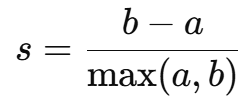

If s ≈ 1, the point is very well clustered.

If s ≈ 0, the point is on the border between two clusters.

If s < 0, it may be misclassified.

I am using this metric because this score gives an idea of how "tight" and "separate" the clusters are, which is useful since I don't have ground truth labels. It helps me judge the overall quality of clustering.

### Davies–Bouldin Index

**Davies–Bouldin Index (DBI)** :    

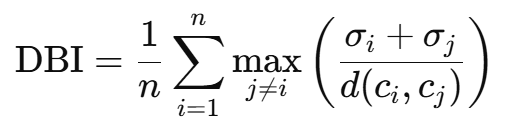

Here :

σ = average distance of points in a cluster to its center.

d = distance between cluster centers.

I have used this as my second evaluation metric to validate what I see from the Silhouette Score. If both are good, the clustering is more reliable. Lower DBI means clusters are compact and well-separated.

In [82]:
def evaluate_clustering(components, labels, algo_name=""):
    """
    Evaluates clustering quality using Silhouette Score and DBI.
    Parameters:
        components: ndarray of shape (n_samples, n_features), input data
        labels: array-like, cluster labels assigned to each sample
        algo_name: str, name of algorithm for print/logging
    Returns:
        Tuple (silhouette_score, dbi)
    """
    mask = labels != -1
    filtered_data = components[mask]
    filtered_labels = labels[mask]

    if len(set(filtered_labels)) < 2:
        print(f"{algo_name}: Not enough clusters to compute metrics.")
        return None, None

    sil = silhouette_score(filtered_data, filtered_labels)
    dbi = davies_bouldin_score(filtered_data, filtered_labels)

    print(f"\nEvaluation for {algo_name}")
    print(f"Silhouette Score: {sil:.3f}")
    print(f"Davies–Bouldin Index: {dbi:.3f}")

    return sil, dbi


In [83]:
evaluate_clustering(components, labels_km, "K-Means")
evaluate_clustering(components, labels_fc, "Fuzzy C-Means")
evaluate_clustering(components, labels_db, "DBSCAN")
evaluate_clustering(components, labels_hc, "Hierarchical Clustering")



Evaluation for K-Means
Silhouette Score: 0.305
Davies–Bouldin Index: 1.090

Evaluation for Fuzzy C-Means
Silhouette Score: 0.364
Davies–Bouldin Index: 0.954

Evaluation for DBSCAN
Silhouette Score: 0.301
Davies–Bouldin Index: 0.742

Evaluation for Hierarchical Clustering
Silhouette Score: 0.191
Davies–Bouldin Index: 1.424


(np.float64(0.19095952649006226), np.float64(1.4236083812024278))

## Conclusion

1. Fuzzy C-Means is the best overall with the highest Silhouette score. Good DBI score too.

2. DBSCAN gives best Davies-Bouldin Index (0.742).

3. K Means is decent but not best. Scores are moderate.

4. Hierarchical Clustering underperforms. Silhouette score is low (0.191). DBI is high (1.424).